In [4]:
import sys
# sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/gmm_ubm', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [52]:
# test for gmm-ubm on whale calls
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
from collections import Counter
import misc.vad as vad
from sklearn.mixture import GaussianMixture, _gaussian_mixture
reload(vad)
import numpy as np
from scipy.special import logsumexp
eps = np.finfo(np.float64).eps

In [7]:
# 27 files in total
# test = 5
# enrol = 8
# train = 15

datasetFolder = r"/Users/david/Documents/mastersCode/ubm/whale/setup/data_spliced"
ads = myads.AudioDatastore()
ads.populate(datasetFolder,include_sub_folders=True, label_source=True)
Counter(ads.labels).values()
adsTest, adsTrain = myads.split(ads, 5)
adsEnroll, adsTrain = myads.split(adsTrain, 8)
adsTrain, _ = myads.split(adsTrain, 15)
adsNorm, _ = myads.split(ads, 27)

In [47]:
# extract all features and use to get feature normalization
import helper_functions as hf
reload(hf)
all_features = []
for file in adsNorm.files:
    feature = hf.helper_feature_extraction(file)
    all_features.append(feature)

In [49]:
# collect normalization factors
import pickle
normFactors = hf.get_norm_factors(all_features)

In [50]:
train_features = []
for i in range(len(adsTrain.files)):
    train_feature = hf.helper_feature_extraction(adsTrain.files[i], normFactors)
    train_features.append(train_feature)

In [64]:
ubm = GaussianMixture(n_components=32, covariance_type='diag')
train_features_flattened = np.array([item for sublist in train_features for item in sublist])
ubm.fit(train_features_flattened)
print('sklearn model' + str(ubm.score(train_features[0])))

sklearn model-28.484390176316168


In [65]:
# ENROLL

# [4] map enroll
import helper_functions as hf

# do stuff
numComponents = 32
numFeatures = train_features[0].shape[1]
relevanceFactor = 16
speakers = np.unique(adsEnroll.labels)
numSpeakers = len(speakers)
gmmCellArray = []

for i in range(len(speakers)):
    adsTrainSubset = myads.subset(adsEnroll, speakers[i])
    N = np.zeros((1, numComponents))
    F = np.zeros((numFeatures, numComponents))
    S = np.zeros((numFeatures, numComponents))

    for file in adsTrainSubset.files:
        speaker_feature = hf.helper_feature_extraction(file, normFactors)
        if len(speaker_feature) > 0:
            # BW stats, # TODO make this in to function
            n,f,s,l = hf.helper_expectation(speaker_feature, ubm)
            N = N + n
            F = F + f
            S = S + s
        else:
            print('skipping train file because len = 0')
    N = np.maximum(N, eps)

    gmm = hf.helper_maximization(N,F,S,numComponents)

    alpha = N / (N + relevanceFactor)

    mu = (alpha.T*gmm.means_) + ((1-alpha).T*ubm.means_)
    gmm.means_ = mu


    sigma = alpha*(S/N) + (1-alpha)*(ubm.covariances_.T + np.square(ubm.means_).T) - np.square(gmm.means_).T

    sigma = np.maximum(sigma, eps).T
    gmm.covariances_ = sigma

    gmm.precisions_cholesky_ = _gaussian_mixture._compute_precision_cholesky(gmm.covariances_, 'diag')

    weights = alpha*(N/np.sum(N)) + (1-alpha)*ubm.weights_.T
    weights = np.squeeze(weights/np.sum(weights))
    gmm.weights_ = weights

    gmmCellArray.append(gmm)

print('speaker enrollment complete')


speaker enrollment complete


In [66]:
adsTrainSubset = myads.subset(adsEnroll, speakers[0])
speaker_feature = hf.helper_feature_extraction(adsTrainSubset.files[1], normFactors)
adapted_score = gmmCellArray[0].score(speaker_feature)
ubm_score = ubm.score(speaker_feature)
print(adapted_score, ubm_score)

-36.37366943787317 -41.134242852415


In [67]:
enrolled_gmms = {}
for i in range(len(gmmCellArray)):
    enrolled_gmms[speakers[i]] = gmmCellArray[i]

In [68]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [69]:
# false rejection rate -
# The speaker false rejection rate (FRR) is the rate that a given speaker is incorrectly rejected. Use the known speaker set to determine the speaker false rejection rate for a set of thresholds.

llr = []

for i in range(len(speakers)):
    cur_speaker = speakers[i]
    local_gmm = enrolled_gmms[cur_speaker]
    adsTestSubset = myads.subset(adsTest, cur_speaker)
    llrPerSpeaker = np.zeros(len(adsTestSubset.files))

    for y in range(len(adsTestSubset.files)):
        file = adsTestSubset.files[y]
        speaker_feature = hf.helper_feature_extraction(file, normFactors)

        if len(speaker_feature) > 0:

            logLikelihood = local_gmm._estimate_weighted_log_prob(speaker_feature)
            lspeaker = logsumexp(logLikelihood, axis=1)

            logLikelihood = ubm._estimate_weighted_log_prob(speaker_feature)
            lubm = logsumexp(logLikelihood, axis=1)

            llrPerSpeaker[y] = np.mean(running_mean(lspeaker-lubm, 3))

    llr.append(llrPerSpeaker)

In [70]:
llr_cat = np.concatenate(llr, axis=0)
thresholds = np.arange(-0.5,2.5,0.01)
thresholds = np.expand_dims(thresholds, axis=1)
ones = np.ones((1, len(llr_cat)))
thresholds = thresholds * ones
frr = np.mean((llr_cat < thresholds), axis=1)

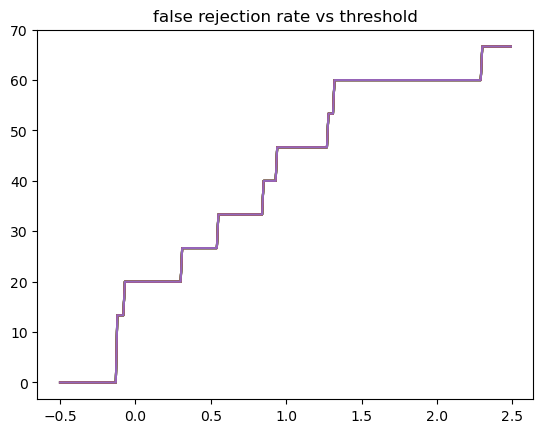

In [71]:
import matplotlib.pyplot as plt

plt.plot(thresholds, frr * 100)
plt.title('false rejection rate vs threshold')
plt.show()

In [72]:
# confusion matrix

# false rejection rate -
# The speaker false rejection rate (FRR) is the rate that a given speaker is incorrectly rejected. Use the known speaker set to determine the speaker false rejection rate for a set of thresholds.

all_whales = []
for i in range(len(speakers)):
    whale_model = enrolled_gmms[speakers[i]]
    cur_whale = []

    # loop through data
    for y in range(len(speakers)):
        dataSubset = myads.subset(adsTest, speakers[y])
        data_ll = []

        for z in range(len(dataSubset.files)):
            file = dataSubset.files[z]
            whale_feature = hf.helper_feature_extraction(file, normFactors)

            logLikelihood = whale_model._estimate_weighted_log_prob(whale_feature)
            lspeaker = logsumexp(logLikelihood, axis=1)

            logLikelihood = ubm._estimate_weighted_log_prob(whale_feature)
            lubm = logsumexp(logLikelihood, axis=1)

            data_ll.append(np.mean(running_mean(lspeaker-lubm, 3)))

        cur_whale.append(np.mean(data_ll))

    all_whales.append(cur_whale)

np.array(all_whales)

array([[ 1.55391908, -1.15144737, -1.02500332],
       [-0.44586417,  9.97429716, -0.43248312],
       [-1.34122677, -1.38601136,  1.20679867]])

In [30]:
pickle.dump(np.array(all_whales), open('mfcc_base_result.pickle','wb'))

In [ ]:
# MFCC base result
# [[ 0.85938588, -0.32007101, -0.59410135],
# [-0.40123801,  5.29921182, -0.40368823],
# [-0.61298323, -0.19562526,  1.16089304]]

# MFCC + deltas
# 1.553919,-1.151447,-1.025003
# -0.445864,9.974297,-0.432483
# -1.341227,-1.386011,1.206799
